# Setup

In [2]:
import sys
sys.path.append('/mnt/c/Users/Arnisa/Desktop/MP/mp-tl-study')
from functions.visualization_utils import *

## Load Data

In [9]:
# load baselines: filename!!
with open('results/baselines_freeze_True_pool_False_lr_0.001_fattest_run.json', 'r') as f:
    baselines = json.load(f)
baselines = baselines[1:]

# load results; filename
with open('results/results_freeze_True_reinit_True_pool_False_lr_0.001_fattest_run.json', 'r') as f:
    results = json.load(f)

# Run this if the first element of the results is the PARAMS dict
params = results[0]
results = results[1:]
# if not, initialize a params dict -see 3. Init params

data_dicts = baselines + results 
# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_dicts)

# Rename the columns to match the specified names
df.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': 'Cut Point',
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

# Display the DataFrame (showing the first few rows for brevity)
df.head()

,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy
0,0.001,0.001,-1,0,1.0,0.792635
1,0.001,0.001,-1,1,1.0,0.754166
2,0.001,0.001,-1,2,1.0,0.761777
3,0.001,0.001,-1,3,1.0,0.798190
4,0.001,0.001,-1,4,1.0,0.735857


In [5]:
# Filter the baselines to these percentages: 0.001, 0.01, 0.1, 0.5, 1.0
# because there are some extra percentages
baselines = [result for result in baselines if result["sampled_percentage"] in [0.001, 0.01, 0.1, 0.5, 1.0]]

results = [result for result in results if result["sampled_percentage"] in [0.001, 0.01, 0.1, 0.5, 1.0]]
data_dicts = baselines + results 
# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_dicts)

# Rename the columns to match the specified names
df.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': 'Cut Point',
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

# Display the DataFrame (showing the first few rows for brevity)
df.head()

,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy
0,0.001,0.001,-1,0,1.0,0.792635
1,0.001,0.001,-1,1,1.0,0.754166
2,0.001,0.001,-1,2,1.0,0.761777
3,0.001,0.001,-1,3,1.0,0.798190
4,0.001,0.001,-1,4,1.0,0.735857


In [33]:
# OR LOAD ARI Scores
"""with open("results_jsons/ari/ari_scores_finetuned_Fashion_to_MNIST.json", "r") as f:
    ari_scores_all = json.load(f)
df_ari = pd.DataFrame(ari_scores_all)

# Display the DataFrame (showing the first few rows for brevity)
df_ari.head()"""

# 1. The plots
See the documentation (mp-tl-study/example_visualizations.ipynb) for a full list of supported visualizations

### Experimental Plots

/home/arnisa/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/arnisa/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


<module 'matplotlib.pyplot' from '/home/arnisa/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

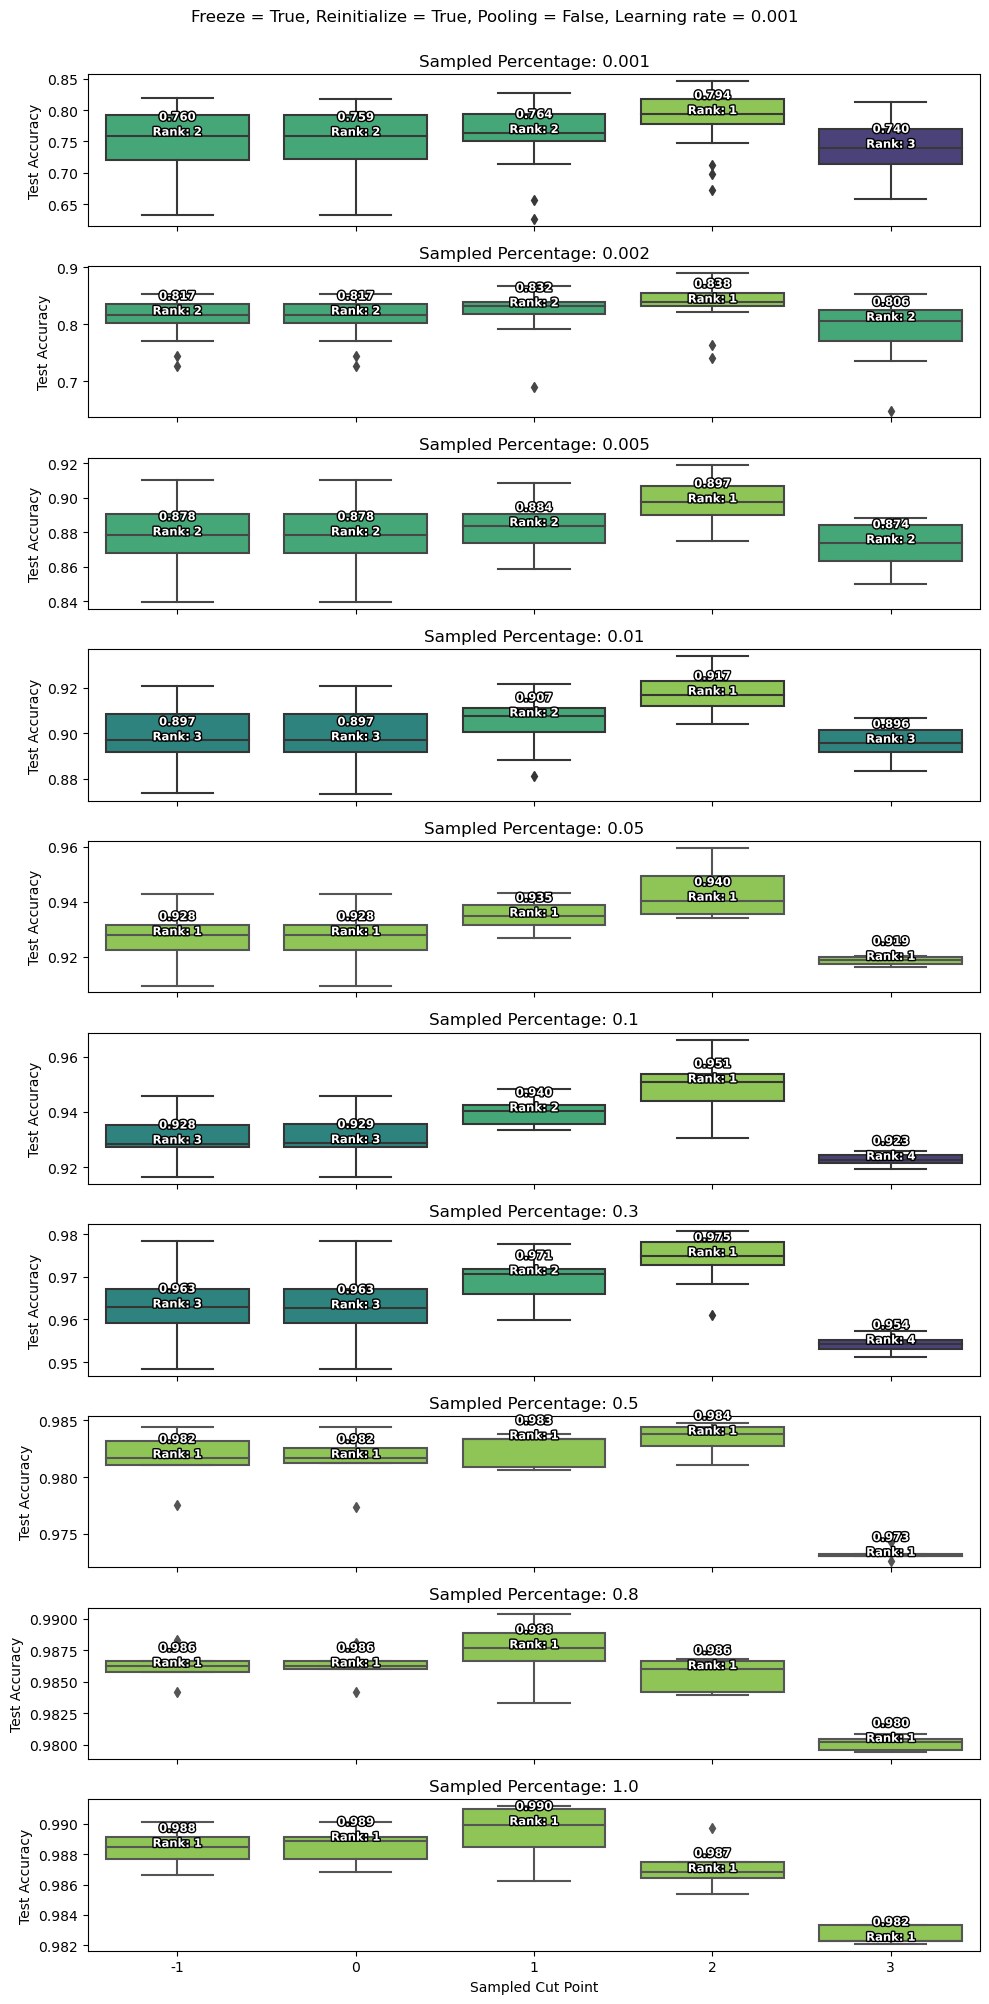

In [10]:
# run statistical tests below to get the df_rankings
df_rankings = pairwise_comparison(df=df)
box_plot_percentages_experiments(df=df, rank_df=df_rankings, color_ranks=True, params=params)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

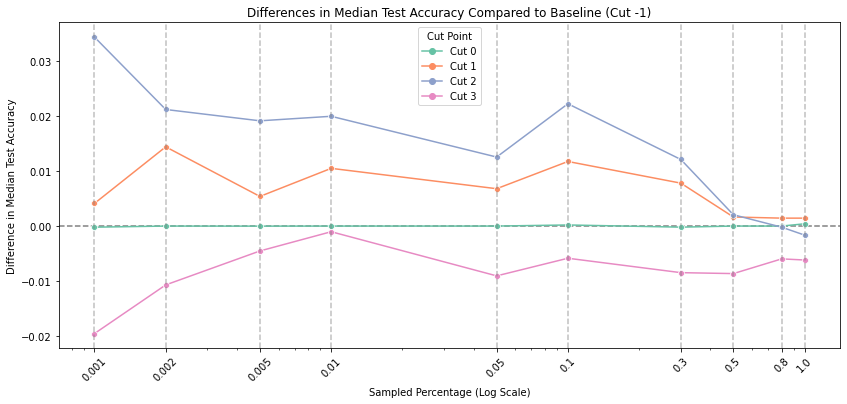

In [6]:
compare_to_baseline_line_plot(df)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

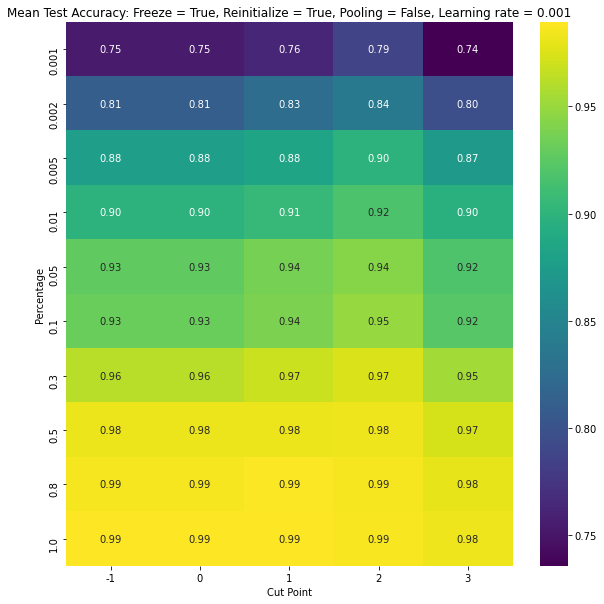

In [7]:
heatmap(df, params, figsize=(10,10))

# 2. Statistical Tests

### a. Significantly better than baseline?

In [7]:
median_baseline = df[df['Cut Point'] == -1].groupby('Percentage')['Test Accuracy'].median()
df_with_baseline = df.merge(median_baseline, on='Percentage', suffixes=('', '_baseline'))
df_with_baseline['diff_to_baseline'] = df_with_baseline['Test Accuracy'] - df_with_baseline['Test Accuracy_baseline']
df_differences = df_with_baseline[df_with_baseline['Cut Point'] != -1]

from scipy.stats import wilcoxon
import numpy as np

def perform_wilcoxon_test(data, baseline_median, cut_point):
    cut_data = data[data['Cut Point'] == cut_point]['Test Accuracy']
    baseline_data = np.full(len(cut_data), baseline_median)  # Creating an array of baseline values

    # Performing the Wilcoxon signed-rank test
    stat, p_value = wilcoxon(cut_data, baseline_data)
    return stat, p_value

# Performing the test for each cut point and sampled percentage
wilcoxon_corrected_results = []
for percentage in df_differences['Percentage'].unique():
    baseline_median = median_baseline[percentage]
    for cut_point in df_differences[df_differences['Cut Point'] != -1]['Cut Point'].unique():
        subset = df_differences[(df_differences['Percentage'] == percentage) & (df_differences['Cut Point'] == cut_point)]
        stat, p_value = perform_wilcoxon_test(subset, baseline_median, cut_point)
        wilcoxon_corrected_results.append({
            'Percentage': percentage,
            'Cut Point': cut_point,
            'statistic': stat,
            'p_value': p_value
        })

# Converting the results to a DataFrame for easier visualization
df_wilcoxon_corrected = pd.DataFrame(wilcoxon_corrected_results)


/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if ther

In [8]:
# add a columns saying if the p-value is significant or not
df_wilcoxon_corrected['is_significant'] = df_wilcoxon_corrected['p_value'] < 0.05
df_wilcoxon_corrected

,Percentage,Cut Point,statistic,p_value,is_significant
0,0.001,0,146.5,6.720752e-01,False
1,0.001,1,120.0,2.634761e-01,False
2,0.001,2,66.0,8.068800e-03,True
3,0.001,3,67.0,8.822322e-03,True
4,0.002,0,136.0,6.891415e-01,False
5,0.002,1,74.0,1.597297e-02,True
6,0.002,2,46.0,1.027107e-03,True
7,0.002,3,96.5,7.547957e-02,False
8,0.005,0,160.0,9.578450e-01,False
9,0.005,1,94.0,6.670159e-02,False


### b. Are any cuts significantly different from each other? (and also rankings)

In [7]:
# Assuming df_combined is your original DataFrame
df_differences = df[df['Cut Point'] != -1]

def perform_wilcoxon_test(group, cut_point_1, cut_point_2):
    data_1 = group[group['Cut Point'] == cut_point_1]['Test Accuracy']
    data_2 = group[group['Cut Point'] == cut_point_2]['Test Accuracy']

    # Ensure equal length by trimming or padding
    min_len = min(len(data_1), len(data_2))
    data_1, data_2 = data_1[:min_len], data_2[:min_len]

    stat, p_value = wilcoxon(data_1, data_2)
    return stat, p_value

# Perform pairwise comparison for each sampled_percentage
wilcoxon_pairwise_results = []

for percentage in df_differences['Percentage'].unique():
    group = df_differences[df_differences['Percentage'] == percentage]
    cut_points = group['Cut Point'].unique()

    for i in range(len(cut_points)):
        for j in range(i + 1, len(cut_points)):
            stat, p_value = perform_wilcoxon_test(group, cut_points[i], cut_points[j])
            wilcoxon_pairwise_results.append({
                'Percentage': percentage,
                'Cut Point 1': cut_points[i],
                'Cut Point 2': cut_points[j],
                'statistic': stat,
                'p_value': p_value
            })

# Converting the results to a DataFrame
df_wilcoxon_pairwise = pd.DataFrame(wilcoxon_pairwise_results)


/home/arnisa/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/arnisa/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [11]:
# add a columns saying if the p-value is significant or not
df_wilcoxon_pairwise['is_significant'] = df_wilcoxon_pairwise['p_value'] < 0.05
df_wilcoxon_pairwise

,Percentage,Cut Point 1,Cut Point 2,statistic,p_value,is_significant
0,0.001,0,1,117.0,2.303613e-01,False
1,0.001,0,2,33.0,1.878738e-04,True
2,0.001,0,3,86.0,3.933871e-02,True
3,0.001,1,2,23.5,3.814697e-05,True
4,0.001,1,3,58.0,3.780901e-03,True
5,0.001,2,3,13.0,5.245209e-06,True
6,0.002,0,1,92.0,5.875152e-02,False
7,0.002,0,2,21.0,2.664328e-05,True
8,0.002,0,3,114.0,2.002162e-01,False
9,0.002,1,2,63.5,1.345270e-02,True


### Ranking Cuts

In [11]:
df_rankings = pairwise_comparison(df=df)
df_rankings

/home/arnisa/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/arnisa/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,Percentage,Cut Point,rank,median_accuracy
0,0.001,0,2,0.759309
1,0.001,1,2,0.763629
2,0.001,2,1,0.793870
3,0.001,3,4,0.739971
4,0.002,0,2,0.817116
5,0.002,1,2,0.831516
6,0.002,2,1,0.838305
7,0.002,3,2,0.806418
8,0.005,0,2,0.878200
9,0.005,1,2,0.883600


In [ ]:
df_rankings

### c. Are no-reinit and reinit settings significantly different from each other?
Needs readjustments

In [ ]:
# Convert to pandas DataFrames
df_no_reinit = pd.DataFrame(results_no_reinit)
df_reinit = pd.DataFrame(results_reinit)

# Merge the dataframes on data percentage, cut point, and repeat
df_merged = pd.merge(df_no_reinit, df_reinit, on=['sampled_percentage', 'sampled_cut_point', 'repeat'], suffixes=('_no_reinit', '_reinit'))

#eliminate duplicate rows 
df_merged = df_merged.drop_duplicates(subset=['sampled_percentage', 'sampled_cut_point', 'repeat'], keep='first')

# remove cut -1 and cut 3
df_merged = df_merged[df_merged['sampled_cut_point'] != -1]
df_merged = df_merged[df_merged['sampled_cut_point'] != 3]

# Group by percentage and cut point
grouped = df_merged.groupby(['sampled_percentage', 'sampled_cut_point'])

# Perform the Wilcoxon signed-rank test for each group
def perform_wilcoxon_test(group):
    test_acc_no_reinit = group['test_acc_no_reinit'].to_numpy()
    test_acc_reinit = group['test_acc_reinit'].to_numpy()

    stat, p_value = wilcoxon(test_acc_no_reinit, test_acc_reinit)
    return pd.Series({'statistic': stat, 'p_value': p_value})

# Apply the test to each group and reset index
wilcoxon_results = grouped.apply(perform_wilcoxon_test).reset_index()

# Add a column indicating significance
wilcoxon_results['is_significant'] = wilcoxon_results['p_value'] < 0.05

# Display the final results
wilcoxon_results